In [15]:
import cudaq
import dynamiqs as dq

from joblib import Parallel, delayed
import time
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import qr, expm
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import random

In [16]:
import sys
import os

# Redirect stderr to devnull temporarily
stderr_fileno = sys.stderr
sys.stderr = open(os.devnull, 'w')

    

# Helper Functions:

### Normalize:
Make any vector into unit vector using following formula:
### $\bar{|\psi\rangle} = \frac{|\psi\rangle}{\sqrt{⟨\psi|\psi⟩}}$

In [17]:
def normalize(data):
   magnitude = np.sqrt(np.vdot(data,data))
   return data/magnitude

def multi_normalize(states):
    mags = np.sqrt(np.einsum('ij,ij->i', states.conj(),states))
    return states/mags[:,np.newaxis]

### State out vector: 
Used to return state $|\psi_f\rangle$ after n-qubit circuit is applied on the intial state $|\psi_0\rangle = |000 ...0_n\rangle$

In [18]:
def state_out(circuit: cudaq.Kernel, norm = True):
  if norm:
    state = normalize(np.array(cudaq.get_state(circuit), dtype=jnp.complex128))
    return state
  else:
    state = np.array(cudaq.get_state(circuit), dtype=jnp.complex128)
    return state



### Expectation Value
Calculates expectation value of operator given state using following

$ \mathbb{E}[H] = ⟨\psi|H|\psi⟩ $

In [19]:
def exp_val(H, psi):
  Hpsi = np.matmul(H,psi)

  return np.vdot(psi,Hpsi)

### Format States

In [20]:
#----------
def format_state(state):
  return np.array([np.array([ele]) for ele in state])

# take in single state array in form of [a,b,c,d,...]      aka shape = (n,)
# and return back that state in form [[a], [b], [c], [d]...]  aka shape = (n,1)
#----------




#----------
def format_states(states):
  return np.array([format_state(state) for state in states])

# take in array of states in form of:               [ [a,b,c,d...],            aka shape = (m,n)
#                                                     [1,2,3,4...],
#                                                     [Z,Y,X,W...]  ]


# and return back this array of states in form of:  [ [[a],[b],[c],[d]...],    aka shape = (m,n,1)
#                                                     [[1],[2],[3],[4]...],
#                                                     [[Z],[Y],[X],[W]...] ]
#----------


# Cat Qubit Dynamics


The Hamiltonian of the system is given by
$$
\begin{aligned}
\hat{H} &= \hat{H_{\mathrm{2ph}}} + \hat{H_d},\qquad \mathrm{with}\\
\hat{H_{\mathrm{2ph}}} &= g_2 {\hat{a}^\dagger}^2 \hat{b} + g_2^* \hat{a}^2 \hat{b}^\dagger,\\
\hat{H}_d &= \epsilon_d^* \hat{b} + \epsilon_d \hat{b}^\dagger.
\end{aligned}
$$

Here, $\hat{H}_{\mathrm{2ph}}$ is the two-photon exchane Hamiltonian and $\hat{H}_d$ is the buffer drive Hamiltonian.g

Our dissapation is modeled by the jump operator:

$$
\hat{L} = \sqrt{\kappa_b} * \hat{b}
$$

In [21]:
# Define parameters
g2 = 1.0
epsilon_d = -4
kappa_b = 10
na = 32# Hilbert space truncation for memory mode
nb = 4# Hilbert space truncation for buffer mode


a,b = dq.destroy(na,nb)
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))


L = np.sqrt(kappa_b)*b
Ls = [L]


H_2PH = g2 * (a @ a @ b.dag() + a.dag() @ a.dag() @ b)

# Define the Driving Hamiltonian
H_D = epsilon_d * (b + b.dag())

# Define Hamiltonian (using g2 and epsilon_d)
H = H_2PH + H_D



# Attempt 1: Modeling Schrodinger with QR Decomposition

Function to return circuit that uses Q-R decomposition to decompose a non-unitary $mxm$ matrix $H$ into a unitary matrix $Q$ and a upper triangular matrix $R$.

Then using this new unitary version of our hamiltonian, we create a unitary gate operation "Q_gate", and put it into a $n = \log_2(m)$ qubit circuit.

 As every circuit begins in the $|\psi_0\rangle ≡ |0_10_20_3...0_n\rangle$ state, this circuit performs the operation

$|\psi_f\rangle = Q|\psi_0\rangle$

In [76]:
def QR_circuit(H: np.array, repeat=1) -> cudaq.Kernel:

    kernel = cudaq.make_kernel()
    n = int(math.log2(len(H)))
    q = kernel.qalloc(n)
    qubits=[]
    for i in range(0,n):
      qubits.append(q[n-i-1])

    Q,R = qr(H)
    cudaq.register_operation("Q_gate",Q)

    for i in range(0,repeat):

      kernel.Q_gate(*qubits)

    return kernel



Here, we do a similar thing, but once we Q-R decompose the non-unitary hamiltonian $H$, we propogate our initial state $|\psi_0⟩$ through time by a small increment $t$ by acting on it by the operator $e^{-iHt}$, replacing the non unitary $H$ with a unitary factor $Q$.

Again starting at the intial state $|\psi_0\rangle ≡ |0_10_20_3...0_n\rangle$

We find the ith state in the interval $0$ to $T$, by taking

$|\psi_i⟩ = e^{-iQt_i}|\psi_0⟩$

where $t_i$ is defined to be $t×i$, with $i ∈ {0,T/t}$


In [81]:
def evolve_QR_1(H: np.array, T, t=0.001, steps=False, norm=True) -> cudaq.Kernel:
    start = time.perf_counter()
    states = []

    repeat = int(T/t)

    for i in range(0,repeat):


      kernel = cudaq.make_kernel()
      n = int(math.log2(len(H)))
      q = kernel.qalloc(n)
      qubits=[]
      for j in range(0,n):
        qubits.append(q[n-j-1])

      Q,R = qr(H)


      Q_step =  expm(-1j*Q*(t*i))
      cudaq.register_operation("Q_step",Q_step)


      if steps:
        print(f"step {i}")
      kernel.Q_step(*qubits)
      state = state_out(kernel,norm=norm)
      states.append(state)


    end = time.perf_counter()
    duration = end-start
    steps = int(T/t)

    print(f"time taken {duration:.6f} seconds")
    print(f"step rate {steps/duration} steps/sec")
    
    return np.array(states)


Same as before, but parallelized

In [27]:
def evolve_QR(H, T, t=0.001, norm=True, steps=False, batch_size=320, n_jobs=16):




    """
    Batched parallel evolution to prevent memory exhaustion.
    Each batch computes a subset of time steps in parallel.
    """

    start = time.perf_counter()

    # --- Precompute constants ---
    Q, _ = qr(H)
    n = int(math.log2(len(Q)))
    times = np.arange(0, T, t)
    total_steps = len(times)
    num_batches = math.ceil(total_steps / batch_size)

    print(f"\nRunning {total_steps} steps in {num_batches} batches "
          f"of {batch_size} (parallel jobs: {n_jobs})")

    # --- Helper: compute matrix exponential ---
    def compute_Q_step(ti):
        return expm(-1j * Q * ti)

    # --- Helper: single evolution step ---
    def evolve_step(i, Q_step, n, norm):
        """Single evolution step running in its own process."""
        cudaq.register_operation(f"Q_step_{i}", Q_step)
        kernel = cudaq.make_kernel()
        q = kernel.qalloc(n)
        qubits = [q[n - j - 1] for j in range(n)]
        kernel.__getattr__(f"Q_step_{i}")(*qubits)
        return state_out(kernel, norm=norm)

    states = []

    # --- Process in batches ---
    for batch in range(num_batches):
        batch_start = time.perf_counter()
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, total_steps)
        batch_times = times[start_idx:end_idx]

        if steps:
            print(f"Batch {batch+1}/{num_batches}: computing {len(batch_times)} Q_steps")

        # Precompute exponentials (NumPy parallel)
        Q_steps = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(compute_Q_step)(ti) for ti in batch_times
        )

        # Run CUDA-Q in parallel (heavier, keep n_jobs smaller)
        batch_states = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(evolve_step)(start_idx + i, Q_steps[i], n, norm)
            for i in range(len(Q_steps))
        )

        states.extend(batch_states)

        batch_end = time.perf_counter()
        batch_time = batch_end-batch_start
        print(f"  ✅ Finished batch {batch+1}/{num_batches} in {batch_time:.6} s")

        # Give OS time to reclaim resources
        time.sleep(0.01)

    end = time.perf_counter()
    duration = end - start
    total = int(T / t)

    print(f"\nTotal time: {duration:.2f} s")
    print(f"Step rate: {(total / duration):.2f} steps/sec "
          f"({(total / duration) * 60:.0f} steps/min)")

    return np.array(states)


# Attempt 2: Modeling Schrodinger with original non-Unitary Hamiltonian

Function that creates a gate that transforms $|\psi_0\rangle$ to the state $|\psi_i\rangle$ at time $t_i$, saving each of these states into an array, modeling the evolution for the intial state $|\psi_0\rangle$ from time $t_i \in [0,T]$ , incrementing by a tiny amount $t$ per step.

- norm set to True will perform amplitude modulation to normalize each state
- steps set to True will print info regarding currently exceuted batch
- batch_size adjusts size of each batch in parallelization
- n_jobs adjusts number of cpu cores used to run in parallel

In [79]:
def evolve(H, T, t=0.001, norm=True, steps=False, batch_size=320, n_jobs=16):




    """
    Batched parallel evolution to prevent memory exhaustion.
    Each batch computes a subset of time steps in parallel.
    """

    start = time.perf_counter()

    # --- Precompute constants ---
    n = int(math.log2(len(H)))
    times = np.arange(0, T, t)
    total_steps = len(times)
    num_batches = math.ceil(total_steps / batch_size)

    print(f"\nRunning {total_steps} steps in {num_batches} batches "
          f"of {batch_size} (parallel jobs: {n_jobs})")

    # --- Helper: compute matrix exponential ---
    def compute_H_step(ti):
        return expm(-1j * H * ti)

    # --- Helper: single evolution step ---
    def evolve_step(i, H_step, n, norm):
        """Single evolution step running in its own process."""
        cudaq.register_operation(f"H_step_{i}", H_step)
        kernel = cudaq.make_kernel()
        q = kernel.qalloc(n)
        qubits = [q[n - j - 1] for j in range(n)]
        kernel.__getattr__(f"H_step_{i}")(*qubits)
        return state_out(kernel, norm=norm)

    states = []

    # --- Process in batches ---
    for batch in range(num_batches):
        batch_start = time.perf_counter()
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, total_steps)
        batch_times = times[start_idx:end_idx]

        if steps:
            print(f"Batch {batch+1}/{num_batches}: computing {len(batch_times)} H_steps")

        # Precompute exponentials (NumPy parallel)
        H_steps = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(compute_H_step)(ti) for ti in batch_times
        )

        # Run CUDA-Q in parallel (heavier, keep n_jobs smaller)
        batch_states = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(evolve_step)(start_idx + i, H_steps[i], n, norm)
            for i in range(len(H_steps))
        )

        states.extend(batch_states)

        batch_end = time.perf_counter()
        batch_time = batch_end-batch_start
        print(f"  ✅ Finished batch {batch+1}/{num_batches} in {batch_time:.6} s")

        # Give OS time to reclaim resources
        time.sleep(0.01)

    end = time.perf_counter()
    duration = end - start
    total = int(T / t)

    print(f"\nTotal time: {duration:.2f} s")
    print(f"Step rate: {(total / duration):.2f} steps/sec "
          f"({(total / duration) * 60:.0f} steps/min)")

    return np.array(states)


# Attempt 3: Linblandian Simulation using Euler-Maruyama numerical method

This uses the numerical method listed in this paper : 

Ding, "Simulating Open Quantum Systems Using Hamiltonian Simulations", journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.5.020332

Using Eqn. 8 we get

$$
|\psi_n\rangle = |\psi_n\rangle + \Delta t(-i\hat{H} - \frac{1}{2} \hat{L}^\dagger\hat{L})|\psi_n\rangle + (\sqrt{\Delta t}*w_n)\hat{L}|\psi_n\rangle
$$
which can be arragned into the singular operator 

$$
\hat{U} = \hat{I} + \Delta t(-i\hat{H} - \frac{1}{2} \hat{L}^\dagger\hat{L}) + + (\sqrt{\Delta t}*w_n)\hat{L},
$$
$$
\hat{U}|\psi_n\rangle = |\psi_{n+1}\rangle
$$
where 

$$
w_n \in Gaussian(\mu = 0, \sigma = 1)
$$
and 
$\hat{L}$ is our jump operator



### 3A: Trying $\hat{U}(t)$

Attempting to create function to do
$$
|\psi(t)\rangle = \hat{U}(t)|\psi_0\rangle
$$

by simply replacing $\Delta t$ with $i * \Delta t$ for the $i$th time step

In [85]:
def L_evolve1(H, L, T, t=0.001, steps=False, norm=True):
    start = time.perf_counter()
    
    dens_mats = []
    L =np.array(L)
    
    repeat = int(T/t)

    
    for i in range(0,repeat):
        if steps:
            print(f"step {i}")
        
        kernel = cudaq.make_kernel()
        n = int(math.log2(len(H)))
        q = kernel.qalloc(n)
        qubits=[]
        for j in range(0,n):
            qubits.append(q[n-j-1])
            
    
        wj = random.gauss(0,1)
        H_step = np.eye(len(H)) + ti*(-1j*H) - 0.5*(L.conj().T@L) + np.sqrt(ti)*wj*L
        H_step = dq.to_numpy(H_step)

        cudaq.register_operation("H_step",H_step)



        kernel.H_step(*qubits)
        state = state_out(kernel)
        print(state)
        dens_mat = np.outer(state,state.conj().T)
        dens_mats.append(dens_mat)
    
    
    end = time.perf_counter()
    duration = end-start
    steps = int(T/t)
    
    print(f"time taken {duration:.6f} seconds")
    print(f"step rate {steps/duration} steps/sec")
    
    return np.array(dens_mats)


In [88]:
def L_evolve2(H, L, T, t=0.001, steps=False, norm=True):
    start = time.perf_counter()
    
    dens_mats = []
    L =np.array(L)
    
    repeat = int(T/t)

    
    kernel = cudaq.make_kernel()
    n = int(math.log2(len(H)))
    q = kernel.qalloc(n)
    qubits=[]
    for j in range(0,n):
        qubits.append(q[n-j-1])
    
    for i in range(0,repeat):
        
    

        
        wj = random.gauss(0,1)
        H_step = np.eye(len(H)) + t*(-1j*H) - 0.5*(L.conj().T@L) + np.sqrt(t)*wj*L
        H_step = dq.to_numpy(H_step)

        cudaq.register_operation("H_step",H_step)


        if steps:
            print(f"step {i}")
        kernel.H_step(*qubits)
        state = state_out(kernel)
        dens_mat = np.outer(state,state.conj().T)
        dens_mats.append(dens_mat)
    
    
    end = time.perf_counter()
    duration = end-start
    steps = int(T/t)
    
    print(f"time taken {duration:.6f} seconds")
    print(f"step rate {steps/duration} steps/sec")
    
    return np.array(dens_mats)

In [87]:


def L_evolve3(H, L, T, t=0.001, steps=False, norm=True):
    start = time.perf_counter()

    L = np.array(L)
    
    H0 = np.sqrt(t)*H
    H1 = L
    H1_dag = L.conj().T
    zeros = np.zeros((len(H),len(H)))
    
    H0_pos = np.array([[1,0],[0,0]])
    H1_pos = np.array([[0,0],[1,0]])
    H1_dag_pos = np.array([[0,1],[0,0]])
    zeros_pos = np.array([[0,0],[0,1]])
    
    H0_part = np.kron(H0_pos,H0)
    H1_part = np.kron(H1_pos,H1)
    H1_dag_part = np.kron(H1_dag_pos,H1_dag)
    zeros_part = np.kron(zeros_pos,zeros)
    
    H_tilda = H0_part + H1_part + H1_dag_part + zeros_part
    

    
    
    
    states = []
    dens_matrs = []
    
    repeat = int(T/t)

    for i in range(0,repeat):
        
        
        kernel = cudaq.make_kernel()
        n = int(math.log2(2*len(H)))
        q = kernel.qalloc(n)
        qubits=[]
        for j in range(0,n):
            qubits.append(q[n-j-1])
        
        
        
        H_step =  expm(-1j*H_tilda*(np.sqrt(t))*i)
        cudaq.register_operation("H_step",H_step)
        

        if steps:
            print(f"step {i}")
        kernel.H_step(*qubits)
        state_full = state_out(kernel,norm=norm)
        
        

        
        
        
        


    end = time.perf_counter()
    duration = end-start
    steps = int(T/t)

    print(f"time taken {duration:.6f} seconds")
    print(f"step rate {steps/duration} steps/sec")
    
    return np.array(dens_mats)



In [28]:
def exp_vals(states,H):
    Psi = np.stack(states,axis=1)
    HPsi = H@Psi
    return np.einsum('ij,ij->j',Psi.conj(),HPsi)

In [29]:
def U_circuit(U: np.array, repeat=1) -> cudaq.Kernel:

    kernel = cudaq.make_kernel()
    n = int(math.log2(len(U)))
    q = kernel.qalloc(n)
    qubits=[]
    for i in range(0,n):
      qubits.append(q[n-i-1])



    cudaq.register_operation("U_gate",U)

    for i in range(0,repeat):

      kernel.U_gate(*qubits)

    return kernel



In [30]:
def circuit_thetas(n: int) -> cudaq.Kernel:

    kernel, thetas = cudaq.make_kernel(list)
    q = kernel.qalloc(n)

    for i in range(0,n):
      kernel.rx(thetas[i],q[i])
      if i > 0:
        kernel.cx(q[0],q[i])

    return kernel


def optimize(circuit, psi_exp):

  def difference(thetas):
    return 1 - np.vdot(psi_exp, state_out(circuit,thetas))

  guess=np.random.rand(len(psi_exp))


  result = minimize(difference,guess)

  return result


Performing Q-R decomposition of the $m×m$ cat-state Hamiltonian and feeding this into dynamiqs.sesolve with an initial state $|\psi_0\rangle = |0_10_2..0_n⟩$ where $n=log(m)$

In [59]:
Q,R = qr(H)
Q = dq.asqarray(Q, dims=(na,nb))


T = 1
t=0.01
steps = int(T/t)
tsave = np.linspace(0,T,steps)


In [64]:
ses = dq.mesolve(H, Ls, psi0, tsave)

In [24]:
ses_states = ses.states
ses_states = np.array(ses_states)
ses_states = np.reshape(ses_states,(len(ses_states),na*nb,))
ses_states = multi_normalize(ses_states)
ses_statesq = dq.asqarray(format_states(ses_states), dims=(na,nb))

ValueError: cannot reshape array of size 1638400 into shape (100,128)

In [89]:
evo_states = L_evolve2(H,L,T,t=t,steps=True)


step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
time taken 36.973283 seconds
step rate 2.704655677622359 steps/sec


In [90]:
evo_states_q = dq.asqarray(evo_states, dims=(na,nb))

In [27]:
evo_energies = np.real(exp_vals(evo_states,Q))

NameError: name 'evo_states' is not defined

In [235]:
#ses_energies = np.real(ses.expects[0])


ses_energies = np.real(exp_vals(ses_states,Q))


Text(0.5, 1.0, 'energies from evolve()')

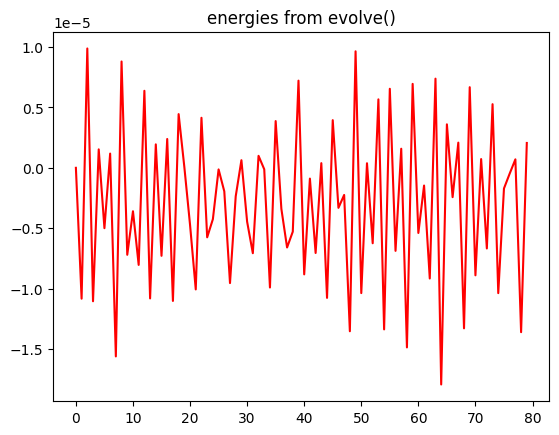

In [236]:
x = np.linspace(0,steps-1,steps)
plt.plot(x,evo_energies,color='r')
plt.title("energies from evolve()")

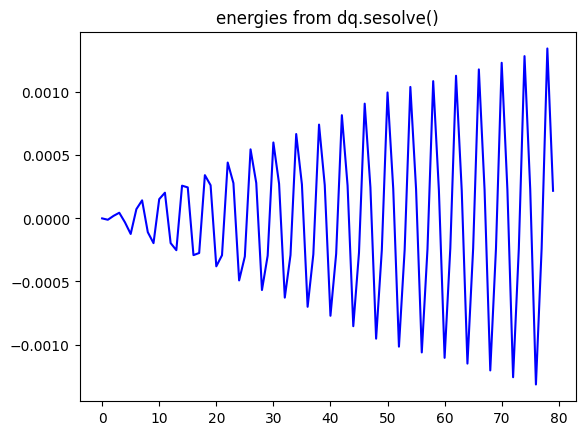

In [237]:
x = np.linspace(0,steps-1,steps)
plt.plot(x,ses_energies,color='b')
plt.title("energies from dq.sesolve()")
plt.show()

In [52]:
ses_rho_a = dq.ptrace(ses.states, 0)

In [49]:
evo_states_q = dq.asqarray(format_states(evo_states), dims=(na,nb))

In [50]:
evo_rho_a = dq.ptrace(evo_states_q, 0)

In [91]:
evo_rho_a = dq.ptrace(evo_states_q,0)
ses_rho_a = dq.ptrace(ses.states, 0)


In [92]:
gif1 = dq.plot.wigner_gif(evo_rho_a, gif_duration = 10, fps=50)
gif2 = dq.plot.wigner_gif(ses_rho_a, gif_duration = 10, fps=50)



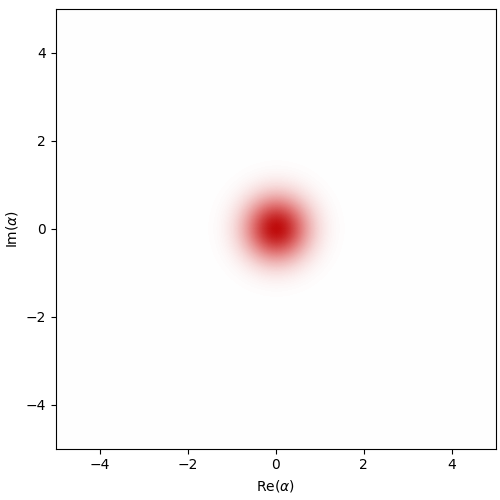

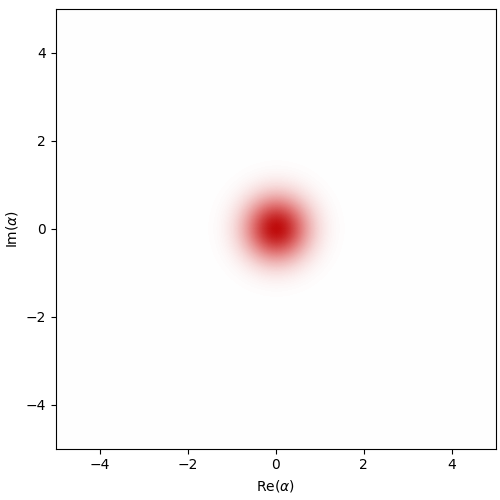

In [93]:
display(gif1)
display(gif2)

In [80]:


curr_min = 10**10
dots = []
for j in range(0, len(evo_states)):

  dot = np.vdot(evo_states[j],ses_states[j])

  if dot < curr_min:
    curr_min = dot
    i = j
    
  dots.append(dot)



print(curr_min)




(0.08181482453402274+0j)


(0.99998, 1.00001)

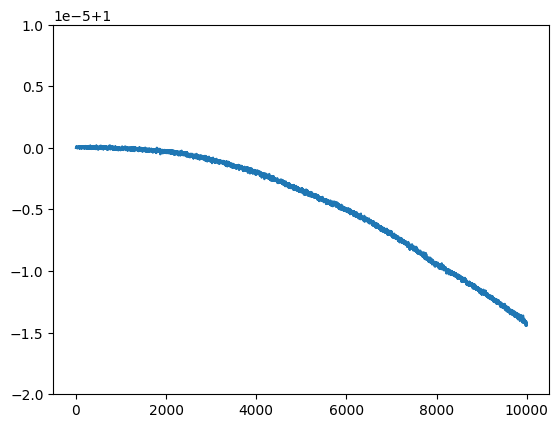

In [188]:
plt.plot(x,np.real(dots))
plt.ylim(0.99998,1.00001)

In [ ]:
for i in range (1,len(states)):
  print(states[i]- states[i-1])

In [ ]:
def circuit2(n: int) -> cudaq.Kernel:

    kernel, thetas = cudaq.make_kernel(list)
    q = kernel.qalloc(n)


    for i in range(0,n):
      kernel.rx(thetas[i],q[i])
      if i > 0:
        kernel.cx(q[0],q[i])
    for i in range(0,n):
      kernel.rx(thetas[i],q[i])
      if i > 0:
        kernel.cx(q[0],q[i])

    return kernel

In [ ]:
np.vdot(state2,psi_exp2)

In [ ]:
print(cudaq.draw(k))


In [ ]:
def apply_with_initial_state(psi0, circuit_kernel, thetas, n):
    # Set global initial statevector
    cudaq.set_state(psi0)

    # Run the circuit on that state
    return cudaq.sample(circuit_kernel, thetas)

In [ ]:
n=5
psi0 = np.zeros(2**n,dtype=complex)

In [ ]:
apply_with_initial_state(psi0,k,[0.2,0.2,0.2,0.2,0.2],n)